<center>
<h1> Startup_Levée_de_fonds </h1>
<center\>

# Initialisation

In [1]:
import re
import string

import numpy as np
import pandas as pd
import squarify

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

%matplotlib inline

import shap

pd.options.mode.chained_assignment = None
from pylab import rcParams
rcParams['figure.figsize'] = 12, 7
font = {'family' : 'normal',
        'weight' : 'medium',
        'size'   : 15}

matplotlib.rc('font', **font)
matplotlib.rcParams['grid.color'] = 'k'
matplotlib.rcParams['grid.linestyle'] = ':'
matplotlib.rcParams['grid.linewidth'] = 0.5

# Chargement des données

In [2]:
data=pd.read_csv("https://drive.google.com/uc?export=download&id=1H3pocHOHB_-EG7ftaVUoopHT51fbIKgF")

In [3]:
data1=pd.read_csv('startup_funding.csv')

In [4]:
data1.head()

,Unnamed: 0,SNo,Date,StartupName,IndustryVertical,SubVertical,City,InvestorsName,InvestmentType,AmountInUSD,Remarks,year,month,yearmonth,CleanedInvestmentType,CleanedAmount
0,0,0,05/09/2019,FPL Technologies,FinTech,Financial Services,Pune,"Matrix Partners India, Sequoia India",Maiden Round,"4,500,000",NaN,2019,9,201909,Other,4500000.0
1,1,1,04/09/2019,Cashflo,FinTech,Invoice discounting platform and SME lending m...,Mumbai,SAIF Partners,Series A,"3,300,000",NaN,2019,9,201909,Series A,3300000.0
2,2,2,04/09/2019,Digital F5,"Advertising, Marketing",Digital marketing firm,Mumbai,TIW Private Equity,Private Equity Round,"6,000,000",NaN,2019,9,201909,Other,6000000.0
3,3,3,04/09/2019,3rdFlix,SaaS,Education Technology,Hyderabad,Exfinity Venture Partners,PreSeries A,"5,000,000",NaN,2019,9,201909,Series A,5000000.0
4,4,4,04/09/2019,75F,IoT,Building automation system,Burnsville,Breakthrough Energy Ventures,Series A,"18,000,000",NaN,2019,9,201909,Series A,18000000.0


In [5]:
data = pd.read_csv("startup_funding.csv").iloc[:, 2:]
data.sample(n=1)

,Date,StartupName,IndustryVertical,SubVertical,City,InvestorsName,InvestmentType,AmountInUSD,Remarks,year,month,yearmonth,CleanedInvestmentType,CleanedAmount
473,21/11/2017,Credit Mate,Technology,Vehicle loan approval platform,Mumbai,Paytm,Private Equity,NaN,NaN,2017,11,201711,Other,NaN


# Exploration et Data Visualization

L'objectif de cette partie est de répondre à des questions que l'on se pose dans le but d'acquérir de la connaissance sur les données. Pour mener à bien cette partie, il faut se mettre dans la tête d'une personne qui ne connaît ni la situation, ni les données et qui poserait des questions essentielles :

- La date a-t-elle un impact sur le montant levé ?
- Certaines villes permettent-elles de lever plus facilement des fonds ?
- Comment les montants levés sont-ils distribués parmi les startups ?

In [6]:
nombre_levees = data["year"].value_counts() # On a sélectionné l'année
nombre_levees

2016    993
2015    936
2017    687
2018    310
2019     83
Name: year, dtype: int64

2015    936
2016    993
2017    687
2018    310
2019     83
Name: year, dtype: int64


[]

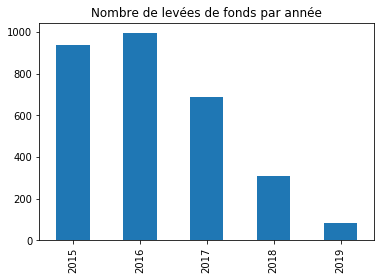

In [8]:
nombre_levees = nombre_levees.sort_index() # On range dans l'ordre croissant pour les années
print(nombre_levees)
nombre_levees.plot.bar(title="Nombre de levées de fonds par année").plot()

## Quels sont les montants levés ?

In [9]:
df_montants_year = data.groupby('year')['CleanedAmount'].agg(["sum", "mean", "median"]) 
df_montants_year

,sum,mean,median
year,,,
2015,8.673022e+09,1.326150e+07,1500000.0
2016,3.828089e+09,6.532574e+06,1000000.0
2017,1.042931e+10,2.287129e+07,2250000.0
2018,5.122368e+09,1.932969e+07,4000000.0
2019,2.681221e+09,3.393951e+07,9000000.0


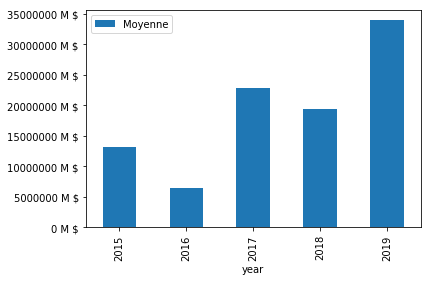

In [10]:
formatter = ticker.FormatStrFormatter('%1.0f M $')
fig = df_montants_year.plot.bar(y="mean", label="Moyenne")
fig.yaxis.set_major_formatter(formatter) # Permet d'afficher en millions

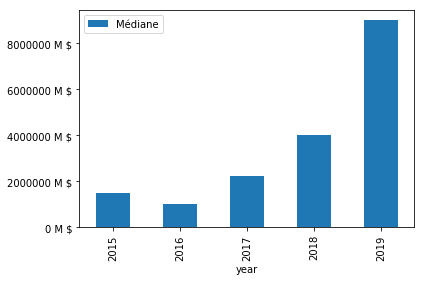

In [11]:
formatter = ticker.FormatStrFormatter('%1.0f M $')
fig = df_montants_year.plot.bar(y="median", label="Médiane")
fig.yaxis.set_major_formatter(formatter) # Permet d'afficher en millions

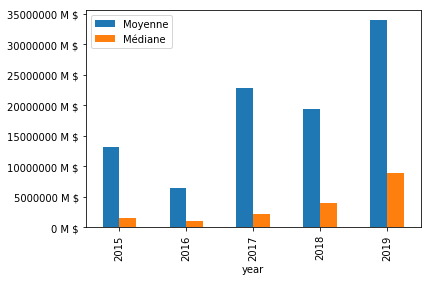

In [12]:
formatter = ticker.FormatStrFormatter('%1.0f M $')
fig = df_montants_year[['mean', 'median']].plot.bar()
fig.legend(["Moyenne", "Médiane"])
fig.yaxis.set_major_formatter(formatter)

## Prédire le montant médian en 2020

[<matplotlib.lines.Line2D at 0x1c1d1679b0>]

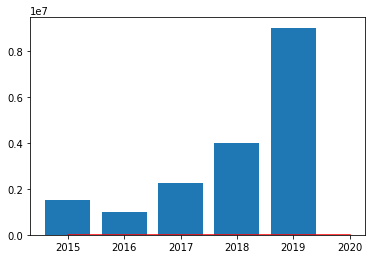

In [13]:
#@title Estimation des montants levés en 2020 { run: "auto" }
a = 1.3 #@param {type:"slider", min:0.4, max:2, step:0.05}
b = 0.75 #@param {type:"slider", min:0, max:2, step:0.05}
plt.bar(df_montants_year.index, df_montants_year['median'])
I = np.linspace(2015, 2020, 200)
plt.plot(I, (a - 0.4) * (I - 2016)**2 + b , color="red")

## Le mois a-t-il une importance ?

In [14]:
df_montants_month = data.groupby('month')['CleanedAmount'].median() / 1e6
df_montants_month

month
1     1.800
2     1.020
3     1.200
4     2.100
5     1.000
6     2.000
7     2.275
8     1.500
9     1.500
10    1.765
11    1.300
12    2.000
Name: CleanedAmount, dtype: float64

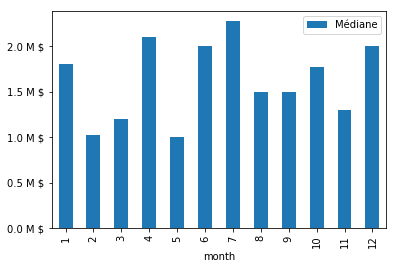

In [15]:
formatter = ticker.FormatStrFormatter('%1.1f M $')
fig = df_montants_month.plot.bar()
fig.legend(["Médiane"])
fig.yaxis.set_major_formatter(formatter)

## Évolution des montants par mois

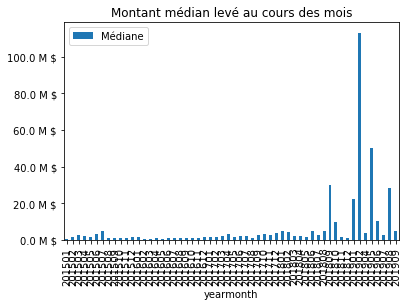

In [16]:
amount_per_yearmonth = data[['yearmonth', 'CleanedAmount']].groupby('yearmonth').agg('median') / 1e6
fig = amount_per_yearmonth.plot.bar(title="Montant médian levé au cours des mois")
fig.legend(['Médiane'])
fig.yaxis.set_major_formatter(formatter)

In [17]:
data[['yearmonth', 'CleanedAmount']].loc[data['yearmonth'] == 201902]

,yearmonth,CleanedAmount
77,201902,NaN
78,201902,226000000.0
79,201902,600000.0


## À-t-on une corrélation entre la ville et les montants levés ?

In [20]:
count = data['City'].value_counts()

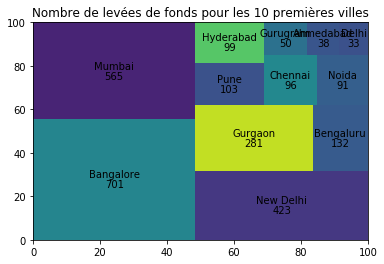

In [21]:
#@title Nombre de ville à afficher
num_cities = 12 #@param {type:"integer"}
count = data['City'].value_counts()[:num_cities]
squarify.plot(sizes=count.values,label=count.index, value=count.values)
plt.title('Nombre de levées de fonds pour les 10 premières villes')
plt.show()

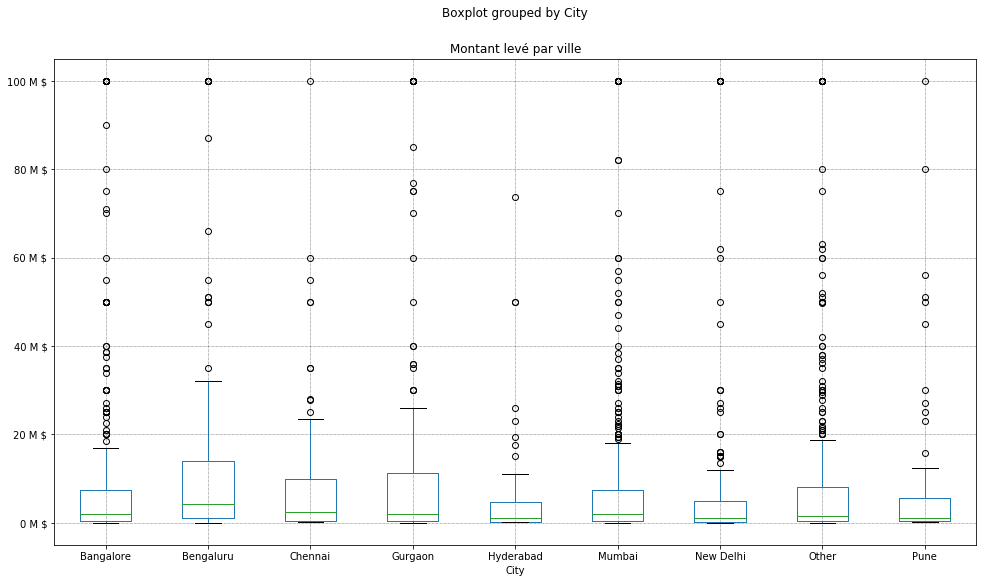

In [22]:
sub_data = data[data['City'] != 'nan'].copy()
counts = sub_data['City'].value_counts()
top_cities = counts.index[:8]

sub_data['City'] = sub_data['City'].apply(lambda x: x if x in top_cities else "Other")
sub_data.loc[sub_data['CleanedAmount'] > 1e8, 'CleanedAmount'] = 1e8
sub_data['CleanedAmount'] = sub_data['CleanedAmount'] / 1e6
sub_data.boxplot(column='CleanedAmount', by='City', figsize=(16,9))

formatter = ticker.FormatStrFormatter('%1.0f M $')
plt.gca().yaxis.set_major_formatter(formatter) # Permet d'afficher en millions
plt.title("Montant levé par ville")
plt.show()

## Quels sont les montants levés pour chaque type d'investissement ?

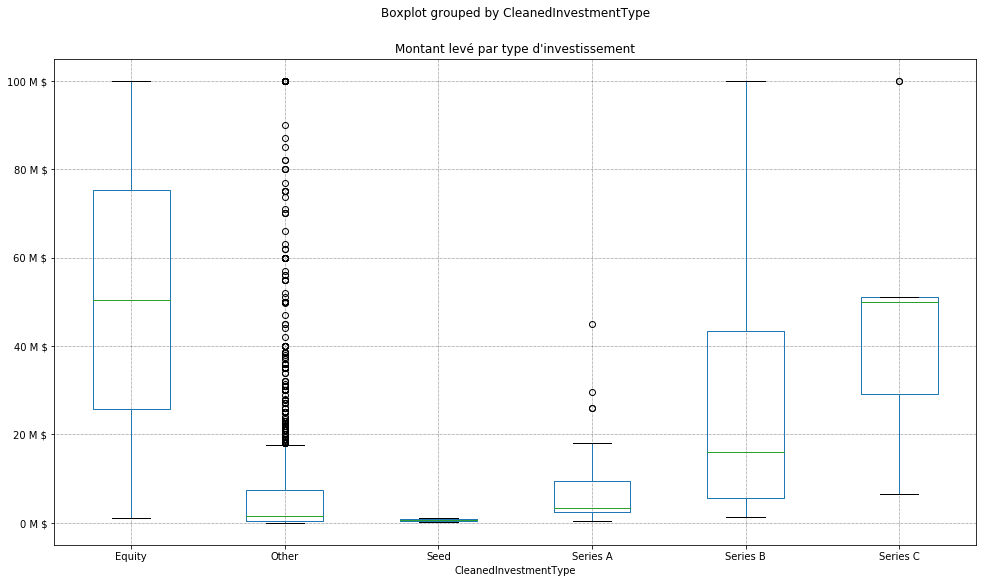

In [23]:
sub_data = data.copy()
sub_data.loc[sub_data['CleanedAmount'] > 1e8, 'CleanedAmount'] = 1e8
sub_data['CleanedAmount'] = sub_data['CleanedAmount'] / 1e6
sub_data.boxplot(column='CleanedAmount', by='CleanedInvestmentType', figsize=(16,9))
formatter = ticker.FormatStrFormatter('%1.0f M $')
plt.gca().yaxis.set_major_formatter(formatter) # Permet d'afficher en euros
plt.title("Montant levé par type d'investissement")
plt.show()

## Y a-t-il des secteurs d'industrie plus propices aux levées de fonds ?

In [24]:
df_montants_industry = data.groupby('IndustryVertical')['CleanedAmount'].agg(["sum", "mean", "median", "count"])
df_montants_industry.head()

,sum,mean,median,count
IndustryVertical,,,,
360-degree view creating platform,0.0,NaN,NaN,0
3D Printer Manufacturer,3000000.0,3000000.0,3000000.0,1
AI,0.0,NaN,NaN,0
API Workflow platform,1000000.0,1000000.0,1000000.0,1
Accounting,5000000.0,5000000.0,5000000.0,1


In [25]:
df_montants_industry.sort_values('sum', ascending=False).iloc[:8,:]

,sum,mean,median,count
IndustryVertical,,,,
E-Commerce,7.338441e+09,3.966725e+07,3000000.0,185
Consumer Internet,6.253084e+09,1.061644e+07,1000000.0,589
Technology,2.203708e+09,7.154896e+06,1500000.0,308
Finance,1.965538e+09,3.509889e+07,7120000.0,56
Online Marketplace,7.001430e+08,3.500715e+08,350071500.0,2
E-Commerce & M-Commerce platform,6.800000e+08,6.800000e+08,680000000.0,1
Ecommerce Marketplace,5.000000e+08,5.000000e+08,500000000.0,1
Car Aggregator & Retail Mobile App,5.000000e+08,5.000000e+08,500000000.0,1


In [26]:
df_montants_industry = df_montants_industry[df_montants_industry['count'] > 10]
df_montants_industry.head()

,sum,mean,median,count
IndustryVertical,,,,
Consumer Internet,6.253084e+09,1.061644e+07,1000000.0,589
E-Commerce,7.338441e+09,3.966725e+07,3000000.0,185
Ed-Tech,3.354864e+07,2.795720e+06,636250.0,12
Education,9.964300e+07,5.861353e+06,1000000.0,17
Finance,1.965538e+09,3.509889e+07,7120000.0,56


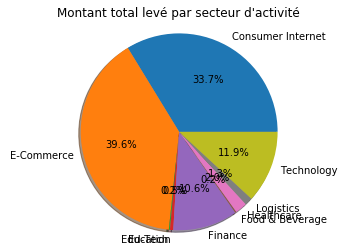

In [27]:
fig1, ax1 = plt.subplots()
explode = np.zeros(df_montants_industry.shape[0])
ax1.pie(df_montants_industry['sum'], labels=df_montants_industry.index, autopct='%1.1f%%',
        shadow=True, startangle=0)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Montant total levé par secteur d'activité")
plt.show()

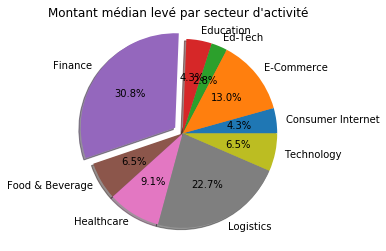

In [28]:
fig1, ax1 = plt.subplots()
explode = np.zeros(df_montants_industry.shape[0])
explode[4] = 0.1
ax1.pie(df_montants_industry['median'], explode=explode, labels=df_montants_industry.index, autopct='%1.1f%%',
        shadow=True, startangle=0)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Montant médian levé par secteur d'activité")
plt.show()

# Modélisation

La modélisation est l'étape clé qui consiste à créer un modèle et à l'entraîner sur les données que nous venons d'étudier. Néanmoins, une phase d'encodage des données est nécessaire afin de permettre au modèle d'effectuer des calculs numériques.

In [29]:
data.head()

,Date,StartupName,IndustryVertical,SubVertical,City,InvestorsName,InvestmentType,AmountInUSD,Remarks,year,month,yearmonth,CleanedInvestmentType,CleanedAmount
0,05/09/2019,FPL Technologies,FinTech,Financial Services,Pune,"Matrix Partners India, Sequoia India",Maiden Round,"4,500,000",NaN,2019,9,201909,Other,4500000.0
1,04/09/2019,Cashflo,FinTech,Invoice discounting platform and SME lending m...,Mumbai,SAIF Partners,Series A,"3,300,000",NaN,2019,9,201909,Series A,3300000.0
2,04/09/2019,Digital F5,"Advertising, Marketing",Digital marketing firm,Mumbai,TIW Private Equity,Private Equity Round,"6,000,000",NaN,2019,9,201909,Other,6000000.0
3,04/09/2019,3rdFlix,SaaS,Education Technology,Hyderabad,Exfinity Venture Partners,PreSeries A,"5,000,000",NaN,2019,9,201909,Series A,5000000.0
4,04/09/2019,75F,IoT,Building automation system,Burnsville,Breakthrough Energy Ventures,Series A,"18,000,000",NaN,2019,9,201909,Series A,18000000.0


## Encodage

In [30]:
X = pd.DataFrame()

In [31]:
X['Month'] = pd.to_datetime(data['Date'], format="%d/%m/%Y").apply(lambda x: x.month)
X.head()

,Month
0,9
1,9
2,9
3,9
4,9


In [32]:
# Industrie
arr = data['IndustryVertical'].value_counts()[:8].index
def sanitize_industry(x):
  if x not in arr:
    return "Other"
  return x

X['IndustryVertical'] = data['IndustryVertical'].apply(sanitize_industry)
X = pd.concat((X, pd.get_dummies(X['IndustryVertical'], prefix = 'Industry')), axis=1).drop(["IndustryVertical"], axis=1)
X = pd.concat((X, pd.get_dummies(data['CleanedInvestmentType'], prefix = 'InvestType')), axis=1)
X.head()

,Month,Industry_Consumer Internet,Industry_E-Commerce,Industry_Education,Industry_Finance,Industry_Food & Beverage,Industry_Healthcare,Industry_Logistics,Industry_Other,Industry_Technology,InvestType_Equity,InvestType_Other,InvestType_Seed,InvestType_Series A,InvestType_Series B,InvestType_Series C
0,9,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
1,9,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
2,9,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
3,9,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
4,9,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0


In [33]:
counts = data['City'].value_counts()
top_cities = counts.index[:8]
X['CleanedCity'] = data['City'].apply(lambda x: x if x in top_cities else "Other")
X = pd.concat((X, pd.get_dummies(X['CleanedCity'], prefix = 'City')), axis=1).drop(["CleanedCity"], axis=1)
X.head()

,Month,Industry_Consumer Internet,Industry_E-Commerce,Industry_Education,Industry_Finance,Industry_Food & Beverage,Industry_Healthcare,Industry_Logistics,Industry_Other,Industry_Technology,...,InvestType_Series C,City_Bangalore,City_Bengaluru,City_Chennai,City_Gurgaon,City_Hyderabad,City_Mumbai,City_New Delhi,City_Other,City_Pune
0,9,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,9,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
2,9,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
3,9,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,9,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0


In [34]:
bins = np.asarray([1e6])
y = np.digitize(data['CleanedAmount'], bins)
X.head()

,Month,Industry_Consumer Internet,Industry_E-Commerce,Industry_Education,Industry_Finance,Industry_Food & Beverage,Industry_Healthcare,Industry_Logistics,Industry_Other,Industry_Technology,...,InvestType_Series C,City_Bangalore,City_Bengaluru,City_Chennai,City_Gurgaon,City_Hyderabad,City_Mumbai,City_New Delhi,City_Other,City_Pune
0,9,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,9,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
2,9,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
3,9,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,9,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0


## Entraînement d'un modèle

Avant d'entraîner un modèle, il faut s'assurer que l'on sépare bien le jeu de données en deux ensembles :

- Un ensemble de *train*
- Un ensemble de *test*

In [35]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score

rng = np.random.RandomState(1)
X_reg = np.sort(5 * rng.rand(80, 1), axis=0)
y_reg = np.sin(X_reg).ravel()
y_reg[::5] += 3 * (0.5 - rng.rand(16))
X_test = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]
y_test = np.sin(X_test).ravel()

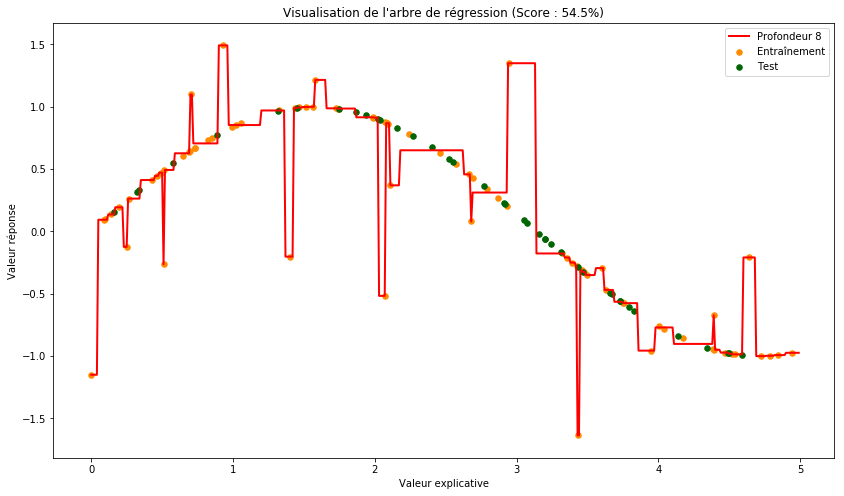

In [36]:
#@title Profondeur { run: "auto" }
profondeur = 8 #@param {type:"slider", min:1, max:8, step:1}
reg = DecisionTreeRegressor(max_depth=profondeur)  # Création d'un arbre de régression de profondeur p
reg.fit(X_reg, y_reg)

plt.figure(figsize=(14, 8))
plt.plot(X_test, reg.predict(X_test), color="red", label="Profondeur {0}".format(profondeur), linewidth=2)
plt.scatter(X_reg, y_reg, s=30, c="darkorange", label="Entraînement")
np.random.seed(43)
I_test = np.random.choice(range(len(X_test)), size=40)
plt.scatter(X_test[I_test], y_test[I_test], s=30, c="darkgreen", label="Test")
plt.xlabel("Valeur explicative")
plt.ylabel("Valeur réponse")
score = r2_score(y_test[I_test], reg.predict(X_test[I_test]))
plt.title("Visualisation de l'arbre de régression (Score : {:2.1f}%)".format(score * 100))
plt.legend()
plt.show()

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
tree = DecisionTreeClassifier(max_depth=12)
tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=12,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [38]:
from sklearn.metrics import accuracy_score

print("Train :", accuracy_score(y_train, tree.predict(X_train)))
print("Test :", accuracy_score(y_test, tree.predict(X_test)))

Train : 0.7730496453900709
Test : 0.7078353253652059


In [39]:
for name, imp in zip(X.columns, tree.feature_importances_):
  print("{} : {:2.1f}%".format(name, imp * 100))

Month : 49.3%
Industry_Consumer Internet : 3.4%
Industry_E-Commerce : 1.5%
Industry_Education : 1.1%
Industry_Finance : 2.2%
Industry_Food & Beverage : 2.4%
Industry_Healthcare : 1.6%
Industry_Logistics : 0.9%
Industry_Other : 3.1%
Industry_Technology : 6.4%
InvestType_Equity : 0.0%
InvestType_Other : 1.8%
InvestType_Seed : 0.8%
InvestType_Series A : 0.0%
InvestType_Series B : 0.0%
InvestType_Series C : 0.0%
City_Bangalore : 1.7%
City_Bengaluru : 4.8%
City_Chennai : 1.7%
City_Gurgaon : 2.4%
City_Hyderabad : 3.3%
City_Mumbai : 2.3%
City_New Delhi : 1.5%
City_Other : 4.5%
City_Pune : 3.2%


# Inteprétabilité

In [40]:
shap.initjs()
explainer = shap.TreeExplainer(tree)
shap_values = np.asarray(explainer.shap_values(X_train))[0]

In [41]:
shap.initjs()
index = 27
shap.force_plot(explainer.expected_value[0], shap_values[index,:], X_train.iloc[index,:])

/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


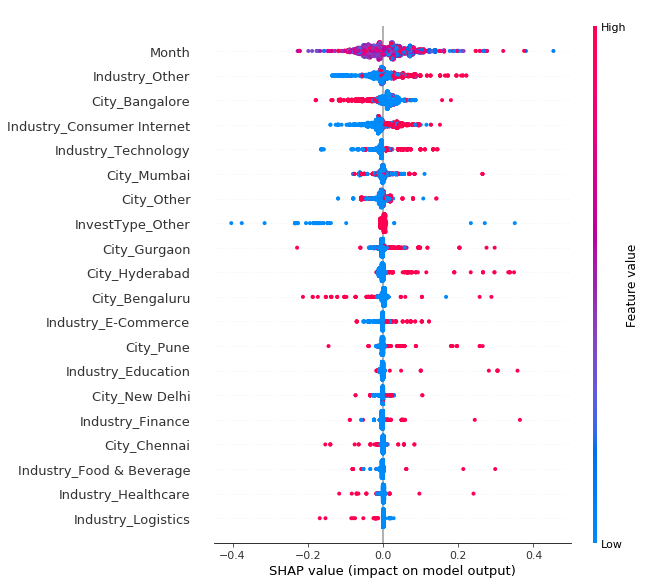

In [42]:
shap.initjs()
shap.summary_plot(shap_values, X_train)